In [ ]:
!pip3 install transformers

In [81]:
import numpy as np
import pandas as pd
import sklearn
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
import sys

In [65]:
df = pd.read_json('products_labeled.json')
df.head()

,Category,Price,Title,Features,Description,Details,SKU,Manufacturer
0,Automotive,NaN,Bosal 813-767 Exhaust Pipe,[Package Dimensions: 5.0 H x 44.0 L x 8.0 W (i...,"[One piece, direct fit exhaust system componen...","{'Manufacturer': 'Bosal', 'Brand': 'Bosal', 'I...",813-767,Bosal
1,Automotive,NaN,NICEASY Bling Diamond Steering Wheel Cover for...,[【Fashionable Design】Fashion charming design o...,[【Fashionable Design】Fashion charming design o...,"{'Manufacturer': 'Hi-Well', 'Brand': 'NICEASY'...",NEYSWC1,Hi-Well
2,Automotive,78.91,WAI World Power Systems World Power Systems DS...,"[World Power Systems DST1835 Distributor, The ...",[Wai Distributors/Wiper Motors Dst1835 New Ign...,"{'Manufacturer': 'WAI World Power Systems', 'B...",DST1835,WAI World Power Systems
3,Automotive,28.58,Tecumseh 40006 Ring Set Std,[],[],"{'Brand': '1PK', 'Manufacturer Part Number': '...",Tecumseh,1PK
4,Musical Instruments,NaN,Nino Percussion Cajon Bag Black,"[Carrying grip, Padded shoulder strap, Padded ...",[The NINO Cajon Bag is designed to supply reli...,"{'Item Weight': '0.6 Kilograms', 'Product Dime...",MNCJB,Nino Percussion


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42429 entries, 0 to 42428
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      42429 non-null  object 
 1   Price         17572 non-null  float64
 2   Title         42429 non-null  object 
 3   Features      42429 non-null  object 
 4   Description   42429 non-null  object 
 5   Details       42429 non-null  object 
 6   SKU           42429 non-null  object 
 7   Manufacturer  42429 non-null  object 
 8   col1_encoded  42429 non-null  int8   
 9   col2_encoded  42429 non-null  int16  
dtypes: float64(1), int16(1), int8(1), object(7)
memory usage: 2.7+ MB


## Training on the Title and Category column 

In [4]:
# combining 'title' and 'manufacturer' columns to get more context
df['Context'] = df['Title'] + " . " + df['Manufacturer']
df = df[['Context', 'Category']]
df.head()

,Context,Category
0,Bosal 813-767 Exhaust Pipe . Bosal,Automotive
1,NICEASY Bling Diamond Steering Wheel Cover for...,Automotive
2,WAI World Power Systems World Power Systems DS...,Automotive
3,Tecumseh 40006 Ring Set Std . 1PK,Automotive
4,Nino Percussion Cajon Bag Black . Nino Percussion,Musical Instruments


## Looking at the Title distribution

<Axes: ylabel='Frequency'>

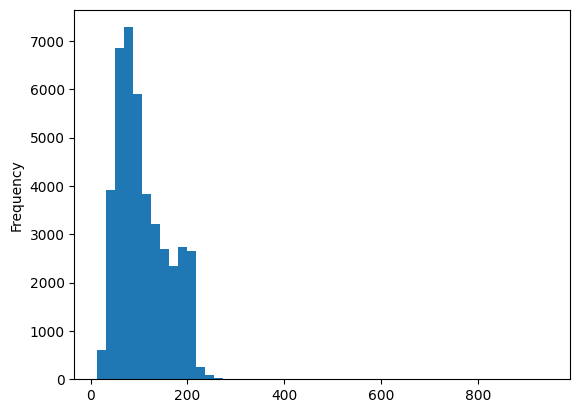

In [5]:
df['Context'].str.len().plot.hist(bins=50)

In [6]:
df['Category'].value_counts()

Category
Fashion                         6420
Home                            5060
Automotive                      4651
Tools & Home Improvement        3245
Sports & Outdoors               2810
All Beauty                      2147
Office Products                 2101
Toys & Games                    2012
Cell Phones & Accessories       1890
Industrial & Scientific         1591
Grocery                         1543
All Electronics                 1463
Computers                       1275
Arts, Crafts & Sewing           1082
Health & Personal Care           929
Pet Supplies                     787
Camera & Photo                   679
Digital Music                    492
Musical Instruments              467
Home Audio & Theater             433
Baby                             332
Appliances                       249
Video Games                      211
Premium Beauty                   200
Car Electronics                  146
Portable Audio & Accessories      73
GPS & Navigation             

## Preprocessing - encoding on the category column

In [7]:
# encoding the category column
df = pd.get_dummies(df, columns=["Category"], prefix='', prefix_sep='', dtype=int)
df.head()

,Context,All Beauty,All Electronics,Appliances,"Arts, Crafts & Sewing",Automotive,Baby,Camera & Photo,Car Electronics,Cell Phones & Accessories,...,Musical Instruments,Office Products,Pet Supplies,Portable Audio & Accessories,Premium Beauty,Software,Sports & Outdoors,Tools & Home Improvement,Toys & Games,Video Games
0,Bosal 813-767 Exhaust Pipe . Bosal,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NICEASY Bling Diamond Steering Wheel Cover for...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,WAI World Power Systems World Power Systems DS...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tecumseh 40006 Ring Set Std . 1PK,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Nino Percussion Cajon Bag Black . Nino Percussion,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [8]:
target_list = [
 'All Beauty',
 'All Electronics',
 'Appliances',
 'Arts, Crafts & Sewing',
 'Automotive',
 'Baby',
 'Camera & Photo',
 'Car Electronics',
 'Cell Phones & Accessories',
 'Computers',
 'Digital Music',
 'Fashion',
 'GPS & Navigation',
 'Grocery',
 'Health & Personal Care',
 'Home',
 'Home Audio & Theater',
 'Industrial & Scientific',
 'Musical Instruments',
 'Office Products',
 'Pet Supplies',
 'Portable Audio & Accessories',
 'Premium Beauty',
 'Software',
 'Sports & Outdoors',
 'Tools & Home Improvement',
 'Toys & Games',
 'Video Games'
]

## Setting the hyperparameters

In [9]:
# hyperparameters
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 1e-05

In [10]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/Users/raenugul/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.title = self.df['Context']
        self.targets = self.df[target_list].values

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs['token_type_ids'].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }
        

In [12]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [13]:
train_dataset = CustomDataset(df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [14]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=0
)
val_data_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [17]:
import torch.nn as nn
class BERTClass(nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(768, len(target_list))

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(input_ids, attention_mask, token_type_ids)
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [18]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [19]:
val_targets=[]
val_outputs=[]

In [89]:
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
   
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    train_loss = train_loss/len(training_loader)
    print('Epoch: {} \tAvgerage Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            ))
      
      # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
    }
        
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    print('############# Epoch {}  Done   #############\n'.format(epoch))
  return model

In [21]:
ckpt_path = "/curr_ckpt"
best_model_path = "/best_model.pt"

In [22]:
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
Epoch: 1 	Avgerage Loss: 0.000118
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
Epoch: 2 	Avgerage Loss: 0.000058
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
Epoch: 3 	Avgerage Loss: 0.000043
############# Epoch 3  Done   #############



## Calculating accuracy on the validation dataset

In [27]:
val_df['ActualCategory'] = val_df[target_list].idxmax(axis=1)
for index, row in val_df.iterrows():
    encodings = tokenizer.encode_plus(
    row['Context'],
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
    )
    trained_model.eval()
    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
        output = model(input_ids, attention_mask, token_type_ids)
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
        val_df.at[index, 'PredictionScoreOrProbability'] = np.max(final_output)
        val_df.at[index, 'PredictedCategory'] = train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))]
Accuracy = ((val_df['ActualCategory'] == val_df['PredictedCategory']).sum())/val_df.shape[0]
print(f"Accuracy is: {Accuracy}")

/var/folders/hs/v_hfp59n3lj2lq14fypgq3km0000gp/T/ipykernel_90573/2648176640.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_df.at[index, 'PredictedCategory'] = train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))]
/var/folders/hs/v_hfp59n3lj2lq14fypgq3km0000gp/T/ipykernel_90573/2648176640.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Office Products' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val_df.at[index, 'PredictedCategory'] = train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))]
/var/folders/hs/v_hfp59n3lj2lq14fypgq3km0000gp/T/ipykernel_90573/2648176640.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, 

Accuracy is: 0.8062691491868961


In [84]:
total_precision = 0
total_recall = 0
# classes with no class imbalance issue
target_list1 = ['Fashion','Home','Automotive','Tools & Home Improvement','Sports & Outdoors','All Beauty','Office Products','Toys & Games']     
for category in target_list1:
    tp = ((val_df['ActualCategory'] == category) & (val_df['PredictedCategory'] == category)).sum()
    fp = ((val_df['ActualCategory'] != category) & (val_df['PredictedCategory'] == category)).sum()
    fn = ((val_df['ActualCategory'] == category) & (val_df['PredictedCategory'] != category)).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    total_precision += precision
    total_recall += recall
print(f"Precision is: {total_precision/len(target_list1)}")
print(f"Recall is: {total_recall/len(target_list1)}")

Precision is: 0.8275086499079471
Recall is: 0.8542101514401468


## Running predictions on the products_unlabeled.json and generating the CSV file

In [30]:
test_df = pd.read_json('products_unlabeled.json')
test_df['Context'] = test_df['Title'] + " . " + test_df['Manufacturer']
test_df = test_df[['Context','Manufacturer','SKU']]
for index, row in test_df.iterrows():
    encodings = tokenizer.encode_plus(
    row['Context'],
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
    )
    trained_model.eval()
    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
        output = model(input_ids, attention_mask, token_type_ids)
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
        test_df.at[index, 'PredictionScoreOrProbability'] = np.max(final_output)
        test_df.at[index, 'PredictedCategory'] = train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))]
test_df = test_df[['Manufacturer','SKU','PredictedCategory','PredictionScoreOrProbability']]
test_df.to_csv('predictions.csv', index=True)

/var/folders/hs/v_hfp59n3lj2lq14fypgq3km0000gp/T/ipykernel_90573/2767294049.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_df.at[index, 'PredictedCategory'] = train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))]
/var/folders/hs/v_hfp59n3lj2lq14fypgq3km0000gp/T/ipykernel_90573/2767294049.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Arts, Crafts & Sewing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_df.at[index, 'PredictedCategory'] = train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))]
/var/folders/hs/v_hfp59n3lj2lq14fypgq3km0000gp/T/ipykernel_90573/2767294049.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depr